In [1]:
# default_exp familiarity

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# The Differential Encoding Mechanism

We intend for the differential encoding mechanism we're integrating into CMR to directly differentiate the strength of memory for spaced repetitions of items relative to that of massed repetitions of items. 

But how exactly does the mechanism work? Here, we'll specify the mechanism and perform some demonstrations exploring:

1. How the mechanism modulates learning as familiarity and parameter values vary
2. How the mechanism shapes model representations under different conditions
3. How these modified model representations then shape predicted behavior, modulating the spacing effect and contiguity with secondary item presentations

## The Mechanism

Lohnas & Kahana (2015) demonstrate that CMR realizes alternative accounts of the spacing effect -- the contextual variability and study-phase retrieval accounts. But the big idea of the deficient encoding hypothesis as an account of the spacing effect is that:
1. Item familiarity ("close acquaintance") impairs attention and memory of subsequent encoding.
2. Repeated experience of an item increases familiarity with that item
3. On the other hand, familiarity decreases with intervening experience, allowing better memory of repetitions



To quantify item familiarity within the operation of CMR, we equate it with the cosine similarity of information in CMR's context vector and the information in the item's representation vector. Two further questions dominate our decision-making about how to implement the mechanism in the context of CMR:
- **What should be the function of familiarity with attention to and/or memory of encoded items?** We know it should be a monotonic decaying function over the range of possible familiarity scores because that's the initial specification. Furthermore, we prefer the effect of familiarity when encoding novel items to be neutral to ensure generalizability results are interpretable. However, a large range of functions have these features. For example, we might try linear, exponential, or a power law function.
- **What operations in CMR model simulation should be modulated by familiarity?** Lohnas & Kahana (2014) suggest that the differential encoding mechanism might modulate the amount of context retrieved for a repeated item - something controlled in a more uniform manner by the encoding drift rate parameter in CMR updating its context representation as each item is processed. On the other hand, Sederberg, Howard & Kahana (2009) account for the role of attention in realizing primacy effects during free recall by modulating the learning rate of context-to-item feature associations encoded in the $M^{CF}$ matrix. And alternatively, item-to-context associations learned in CMR's $M^{FC}$ matrix might be the model operation modulated by familiarity - either alone or along with $M^{CF}$.


### Candidate $\zeta_i$ Functions
We end up preferring a power function between the inverse of familarity (distance) and a free familiarity_scale parameter that either widens or shrinks how much the amount of modulation varies with familiarity. When the parameter has a value of 0, the differential encoding mechanism will have no effect on model simulation. When the parameter has a value of 1, the function is equivalent to a linear function with slope and y-intercept of 1. Above 1, it's an accelerating decay function while below 1 (but above 0) it's a decelerating decay function.

In [2]:
# preferred linear function
familiarity = lambda familiarity_scale, similarity: np.multiply(1-similarity, familiarity_scale) + 1

# power law function
familiarity = lambda familiarity_scale, similarity: np.power(np.multiply(1-similarity, familiarity_scale) + 1, 3) + 1

# exponential function
familiarity = lambda familiarity_scale, similarity: np.power(familiarity_scale, 1-similarity)

# favored decay function
familiarity = lambda familiarity_scale, similarity: np.power(1-similarity, familiarity_scale)

# stepwise function
familiarity = lambda familiarity_scale, similarity: 1 if ((1-similarity) == 0) else familiarity_scale

In [21]:


from numba import njit
import numpy as np

@njit
def familiarity_weighting(familiarity_scale, similarity):
    return 1 if ((1-similarity) == 0) else familiarity_scale

### How Do Values of $\zeta_i$ Vary as a function of Familiarity_Scale and Similarity Values?

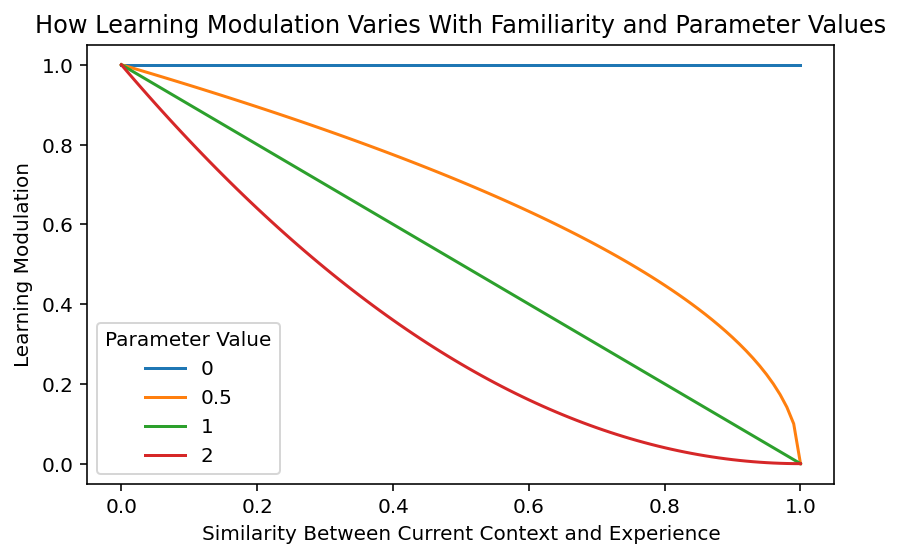

In [22]:
import numpy as np
import matplotlib.pyplot as plt

similarity_values = np.arange(0.00, 1.01, .01)

# range of parameter values considered
scale_range =  [0, .5, 1, 2]

for familiarity_scale in scale_range:
    plt.plot(similarity_values, [familiarity_weighting(familiarity_scale, s) for s in similarity_values], label=str(familiarity_scale))

plt.title('How Learning Modulation Varies With Familiarity and Parameter Values')
plt.ylabel('Learning Modulation')
plt.xlabel('Similarity Between Current Context and Experience')
plt.legend(title='Parameter Value')
plt.tight_layout()
plt.show()

## How Do Values of $\zeta_i$ Configure Model Representations?


$$
\zeta_i = [1 - S(c_i$, $f_i$)]^{\zeta_s}
$$

In the currently considered version of the model, we realize this mechanism through episode-by-episode modulation of $M^{CF}$ learning rate, much like how the primacy effect is enforced in the Morton & Polyn (2016) specification of CMR.

$$
\Delta M^{CF}_{exp} = \zeta_i \phi_i f_i c^{'}_i
$$

where

$$
\zeta_i = \zeta_s [1 - S(f_i, c_i)]
$$

With $S$ as the cosine similarity function and a familiarity_scale parameter $\zeta_s$ controlling the extent to which item familiarity scales learning.

In particular, it intends to reduce context-to-item associations in $M^{CF}$ corresponding to the repeated study item depending on the spacing between item presentations (but also other factors configuring item familiarity, like the rate of contextual drift).

We can visualize this effect by simulating processing of a study list with item repetitions using CMR with different parameter values, and then inspecting the summed support for recall of each item across possible contextual inputs in $M^{CF}$.

[0, 1, 2, 3, 4, 5, 6, 7, 3, 8, 9, 10, 10, 11, 12, 13, 14, 13, 15, 16]


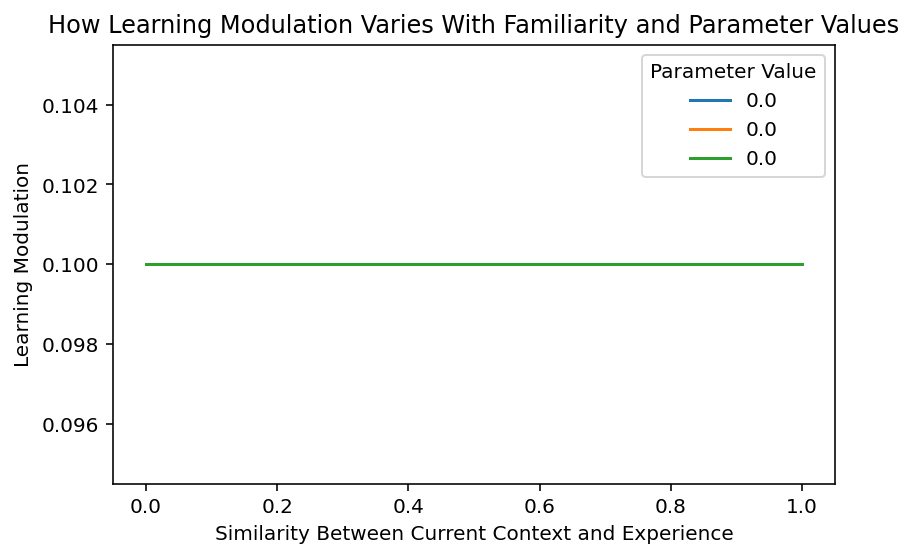

In [13]:
from compmemlearn.models import Classic_CMR

# parameter values
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate']

# three param (drift, mcf, mfc), flat function with room for > 1, f: 29579.721,  nonmonotonic spacing effect
fit_values = [8.28200650e-01, 2.11041843e-01, 7.97662865e-01, 4.34515565e-01,
 1.00000000e+00, 3.88740684e-01, 1.12263975e+00, 5.39979261e+01,
 2.04956075e-02, 1.20033682e-01, 6.05568784e+00, 9.95708565e-01,
 8.62855932e-01, 3.28717846e-01, 1.03136328e+00]

# three param spaced function except drift, f: 29728.806135248666
fit_values = [8.40913011e-01, 1.45223193e-01, 3.30552957e-01, 1.05800113e-01,
 6.80037261e-01, 3.29193178e-01, 2.40848840e+00, 6.40285386e+01,
 2.04854236e-02, 1.20068548e-01, 2.12334575e+00, 9.97222620e-01,
 8.84106307e-01, 1.33006260e+00, 3.88277354e+01]

# 1 param (mfc), spaced function, f: 29754.497
fit_values = [8.46100614e-01, 1.33053790e-01, 9.11369750e-01, 8.26831413e-02,
 9.83960319e-01, 2.84771145e-01, 3.17274031e+00, 7.40691574e+01,
 2.04943244e-02, 1.20065383e-01, 1.73809341e+00, 9.98206857e-01, 0.0, 0.0,
 4.02851270e+01]

# 1 param (drift), spaced function, f: 29703.376
fit_values = [8.47263717e-01, 1.60675298e-01, 9.11892548e-01, 1.04227169e-01,
 1.00000000e+00, 2.91238082e-01, 2.63313448e+00, 4.18583400e+01,
 2.04868224e-02, 1.20049896e-01, 1.92863404e+00, 9.97792294e-01,
 2.22044605e-16, 0.0, 0.0]
  
# 1 param (mcf), spaced function, f: 29643.5036
fit_values = [8.24341352e-01, 1.77225652e-01, 9.10925490e-01, 1.89019740e-01,
 1.00000000e+00, 3.11083773e-01, 2.17438749e+00, 3.16410704e+01,
 2.05006970e-02, 1.20019620e-01, 2.80478189e+00, 9.96111417e-01,
 0.0, 2.13662270e+00, 0.0] 

# 2 param (mfc, mcf), spaced function, f: 29661.62
fit_values = [8.08892781e-01, 1.98681073e-01, 9.00133009e-01, 3.32995777e-01,
 1.00000000e+00, 3.82333695e-01, 1.29798810e+00, 3.47344765e+01,
 2.04904991e-02, 1.20046794e-01, 4.89636556e+00, 9.95083301e-01, 0.0,
 2.22044605e-16, 4.47177260e+01]

 # 2 param (mcf, drift), spaced function, f: 29658.45
fit_values = [8.16425194e-01, 1.90730602e-01, 9.12739696e-01, 3.01841544e-01,
 1.00000000e+00, 3.69237249e-01, 1.46143431e+00, 5.32692473e+01,
 2.04914625e-02, 1.20047100e-01, 4.51585910e+00, 9.95260314e-01,  3.37024215e-01,
 3.32133551e+01, 0.0]



# 1 param (drift), flat function, f: 29698.29
fit_values = [8.37003322e-01, 1.55125201e-01, 8.02889283e-01, 1.14697541e-01,
 1.00000000e+00, 2.90017516e-01, 2.42731709e+00, 3.33539528e+01,
 2.04959893e-02, 1.20036166e-01, 2.07795435e+00, 9.97786674e-01,
 8.96676627e-01, 0.0, 0.0]

# 1 param (mfc), flat function, f: 29701.453
fit_values = [0.84716454, 0.14801061, 0.91243819, 0.09999486, 1.,         0.29194945,
 2.89374896, 9.25589222, 0.02048442, 0.1200557,  1.89120866, 0.99791303, 0.0, 0.0,
 0.83551827]

# three param (drift, mcf, mfc), flat function, f: 29525.391; results in nonmonotonic spacing effect
fit_values = [8.36665617e-01, 2.13784025e-01, 1.00000000e+00, 4.03669013e-01,
 1.00000000e+00, 3.88907155e-01, 1.29771600e+00, 3.28651169e+01,
 2.04955815e-02, 1.20037078e-01, 5.52178782e+00, 9.95764574e-01,
 8.97863247e-01, 2.95128448e-01, 5.85884560e-01]
 
# 2 param (mfc, drift), flat function, f: 30074.267
fit_values = [8.27091399e-01, 1.92707500e-01, 9.21841797e-01, 6.40484494e-02,
 1.18410261e-01, 4.45293635e-01, 2.40281149e+00, 5.85689331e+01,
 2.05000182e-02, 1.20013854e-01, 1.37198804e+00, 9.92006186e-01,
  2.39185788e+01, 0.0, 4.59050606e+01]

# 2 param (mfc, drift), spaced function, f:29750
fit_values = [8.45006331e-01, 1.56884979e-01, 9.10701016e-01, 8.93571229e-02,
 9.96662093e-01, 2.89420818e-01, 2.59282141e+00, 5.79650915e+01,
 2.04837648e-02, 1.20060277e-01, 1.80639172e+00, 9.98013466e-01,
 2.22044605e-16, 0.0, 3.31712618e+01]
 
 # three parameter results (drift, mcf, mfc), spaced function, f: 29541.157215062805, mismeasures spacing effect
fit_values = [ 0.82451469,  0.15889928,  0.91683227,  0.1332841,   1.,          0.29128449,
  3.0126314,   0.58703946,  0.02049913,  0.12002384,  2.15233709,  0.99489324,
  0.45163484,  1.36476747, 19.78352376]

# three parameter results (drift, mcf, mfc), floored function, f: 29561.157215062805
fit_values = [8.29606404e-01, 1.97050890e-01, 9.17870500e-01, 3.65321165e-01,
 1.00000000e+00, 3.89908584e-01, 1.43755490e+00, 4.14652342e+01,
 2.04934427e-02, 1.20049538e-01, 5.22531205e+00, 9.95384348e-01,
 7.90847054e-01, 2.95747995e+01, 4.20302113e+00]

  # base result, f: 29703.113225105808, doesn't account for differential contiguity
fit_values = [8.36412380e-01, 1.37438014e-01, 9.14231622e-01, 1.03548867e-01,
 1.00000000e+00, 2.70091435e-01, 3.89549514e+00, 6.04259249e-01,
 2.04970025e-02, 1.20035161e-01, 1.78302334e+00, 9.96231007e-01,
 0.0, 0.0, 0.0]

parameters = {free_parameters[i]:fit_values[i] for i in range(len(fit_values[:-3]))}
parameters['sampling_rule'] = 0
# presentation scheme
# repeat the 3-indexed item at position 10, and the 10-index item at position 14
presentation = [0, 1, 2, 3, 4, 5, 6, 7, 3, 8, 9, 10, 10, 11, 12, 13, 14, 13, 15, 16]

print(presentation)

for familiarity_scale in fit_values[-3:]:
    plt.plot(similarity_values, [familiarity_weighting(familiarity_scale, s) for s in similarity_values], label=str(familiarity_scale))

plt.title('How Learning Modulation Varies With Familiarity and Parameter Values')
plt.ylabel('Learning Modulation')
plt.xlabel('Similarity Between Current Context and Experience')
plt.legend(title='Parameter Value')
plt.tight_layout()
plt.show()

Here we visualize the effect of familiarity scale on the support for recall of repeated items with different amounts of spacing between presentations. Our third indexed item has the highest amount of spacing between repetitions (4 intervening items), while our 13th has the next highest (1 item) and our 10th has the least (0).

mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.0 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.5 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 1 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 2 0.0


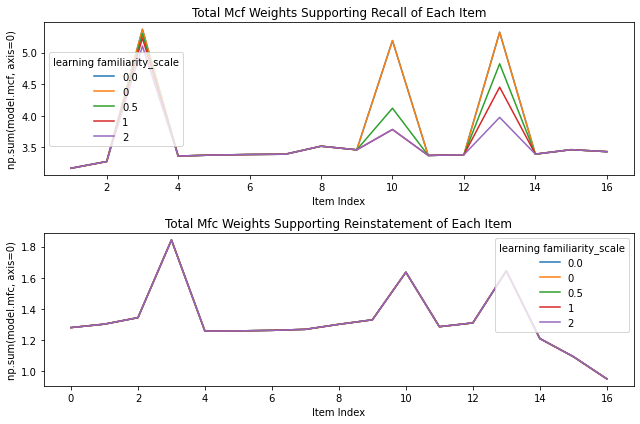

mfc_learning_scale, mcf_learning_scale, drift_scale
0 0.0 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0 0 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0 0.5 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0 1 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0 2 0.0


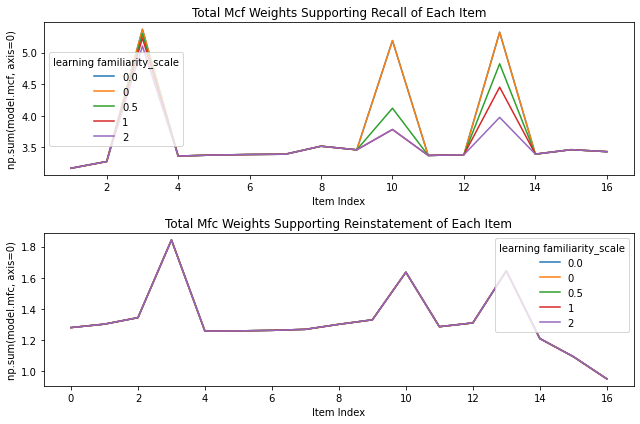

mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0.0 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0.5 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 1 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 2 0.0


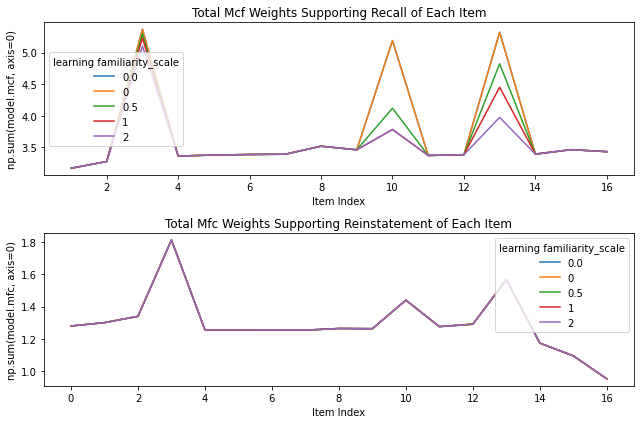

mfc_learning_scale, mcf_learning_scale, drift_scale
1 0.0 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
1 0 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
1 0.5 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
1 1 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
1 2 0.0


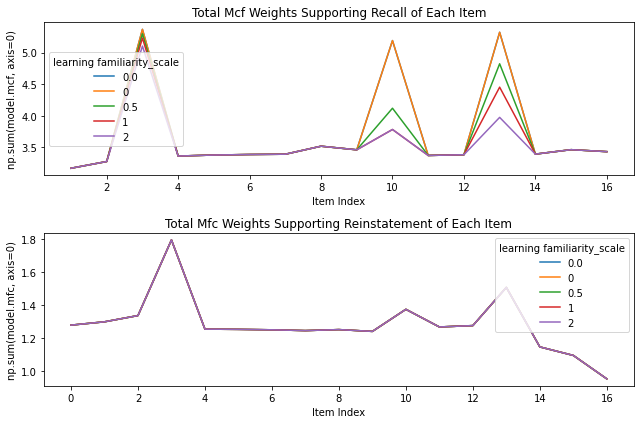

mfc_learning_scale, mcf_learning_scale, drift_scale
2 0.0 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
2 0 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
2 0.5 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
2 1 0.0
mfc_learning_scale, mcf_learning_scale, drift_scale
2 2 0.0


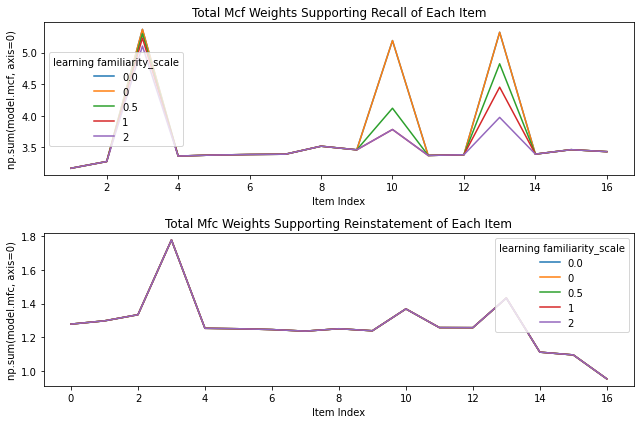

mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.0 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.5 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 1 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 2 0


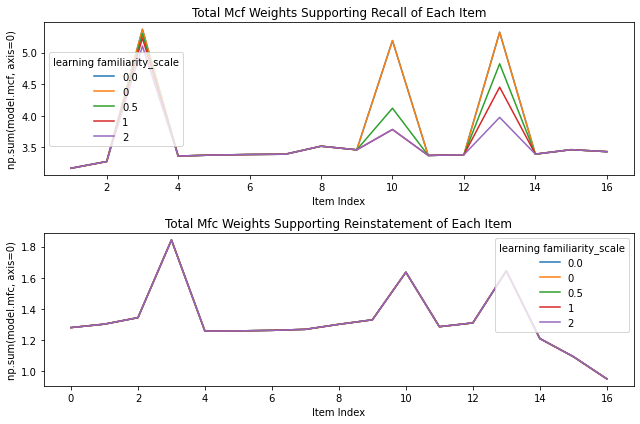

mfc_learning_scale, mcf_learning_scale, drift_scale
0 0.0 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0 0 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0 0.5 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0 1 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0 2 0


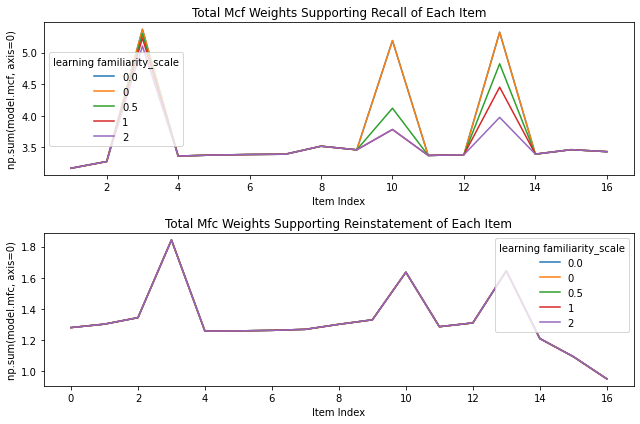

mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0.0 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0.5 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 1 0
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 2 0


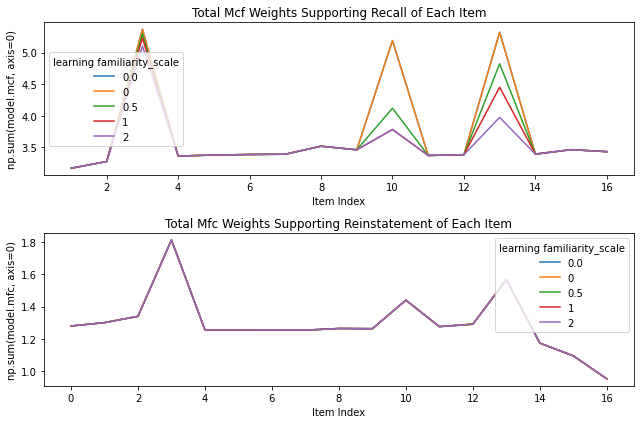

mfc_learning_scale, mcf_learning_scale, drift_scale
1 0.0 0
mfc_learning_scale, mcf_learning_scale, drift_scale
1 0 0
mfc_learning_scale, mcf_learning_scale, drift_scale
1 0.5 0
mfc_learning_scale, mcf_learning_scale, drift_scale
1 1 0
mfc_learning_scale, mcf_learning_scale, drift_scale
1 2 0


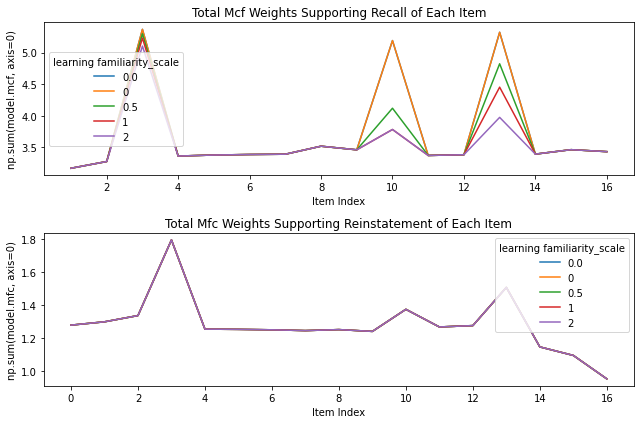

mfc_learning_scale, mcf_learning_scale, drift_scale
2 0.0 0
mfc_learning_scale, mcf_learning_scale, drift_scale
2 0 0
mfc_learning_scale, mcf_learning_scale, drift_scale
2 0.5 0
mfc_learning_scale, mcf_learning_scale, drift_scale
2 1 0
mfc_learning_scale, mcf_learning_scale, drift_scale
2 2 0


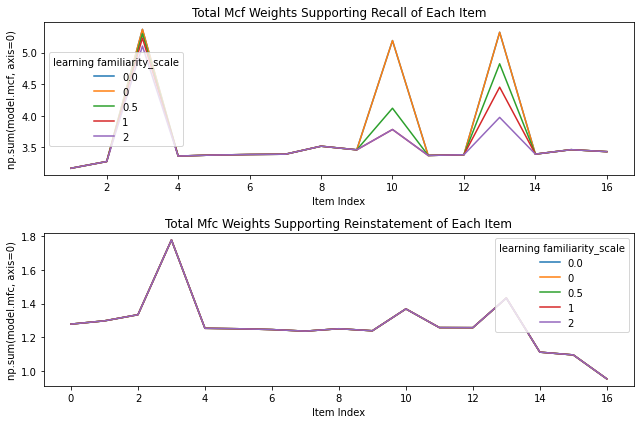

mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.0 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.5 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 1 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 2 0.5


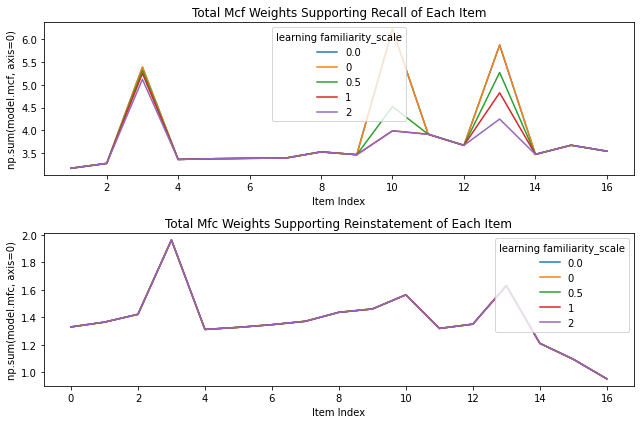

mfc_learning_scale, mcf_learning_scale, drift_scale
0 0.0 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0 0 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0 0.5 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0 1 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0 2 0.5


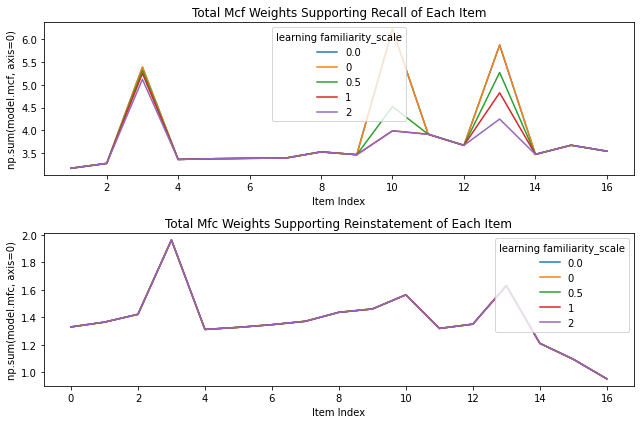

mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0.0 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0.5 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 1 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 2 0.5


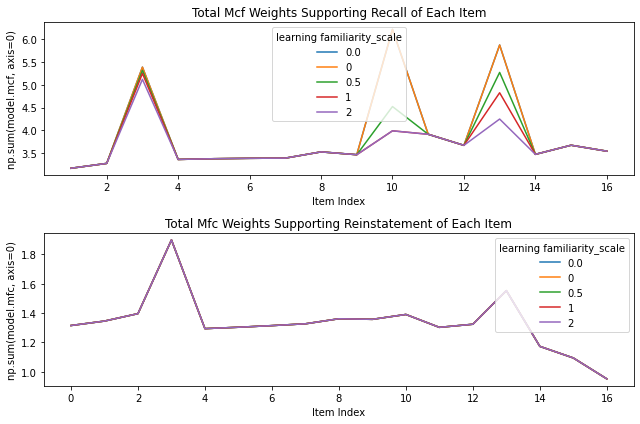

mfc_learning_scale, mcf_learning_scale, drift_scale
1 0.0 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
1 0 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
1 0.5 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
1 1 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
1 2 0.5


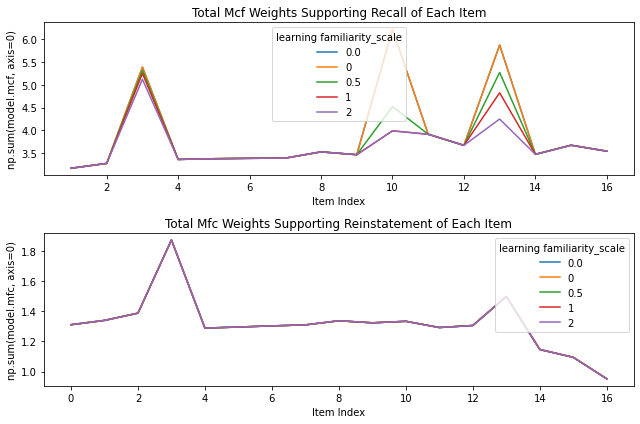

mfc_learning_scale, mcf_learning_scale, drift_scale
2 0.0 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
2 0 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
2 0.5 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
2 1 0.5
mfc_learning_scale, mcf_learning_scale, drift_scale
2 2 0.5


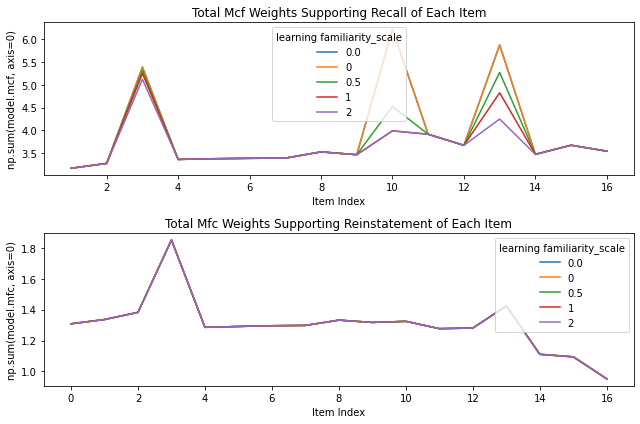

mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.0 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.5 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 1 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 2 1


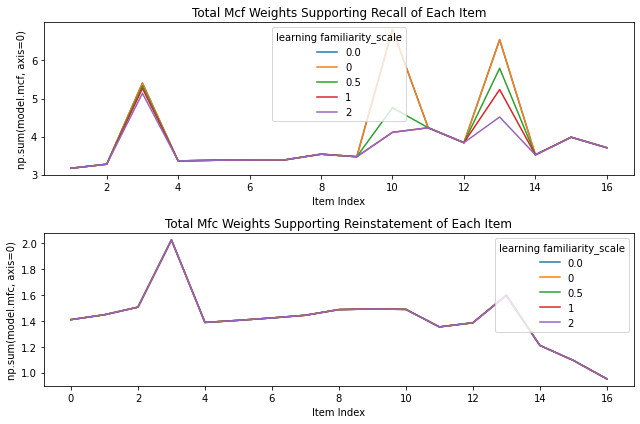

mfc_learning_scale, mcf_learning_scale, drift_scale
0 0.0 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0 0 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0 0.5 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0 1 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0 2 1


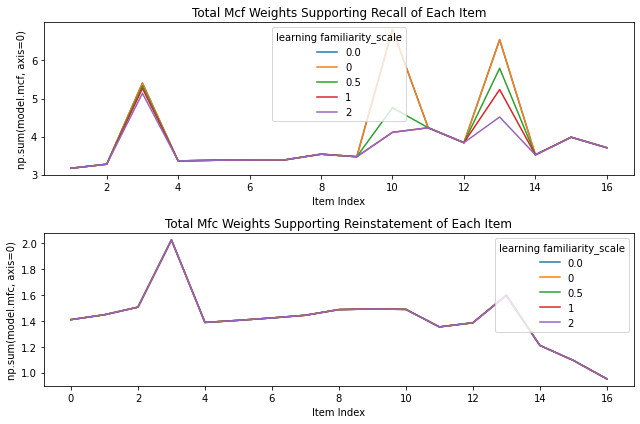

mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0.0 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0.5 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 1 1
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 2 1


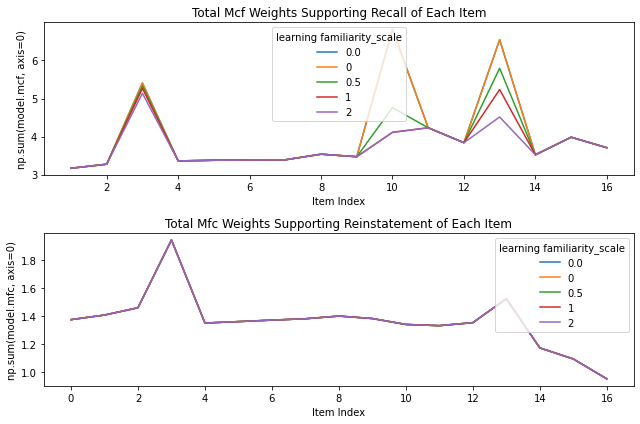

mfc_learning_scale, mcf_learning_scale, drift_scale
1 0.0 1
mfc_learning_scale, mcf_learning_scale, drift_scale
1 0 1
mfc_learning_scale, mcf_learning_scale, drift_scale
1 0.5 1
mfc_learning_scale, mcf_learning_scale, drift_scale
1 1 1
mfc_learning_scale, mcf_learning_scale, drift_scale
1 2 1


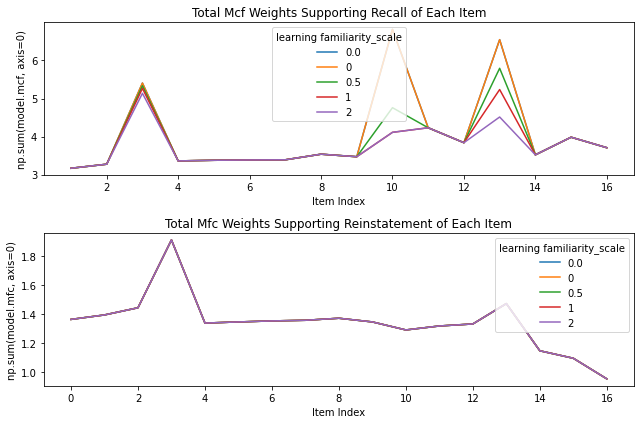

mfc_learning_scale, mcf_learning_scale, drift_scale
2 0.0 1
mfc_learning_scale, mcf_learning_scale, drift_scale
2 0 1
mfc_learning_scale, mcf_learning_scale, drift_scale
2 0.5 1
mfc_learning_scale, mcf_learning_scale, drift_scale
2 1 1
mfc_learning_scale, mcf_learning_scale, drift_scale
2 2 1


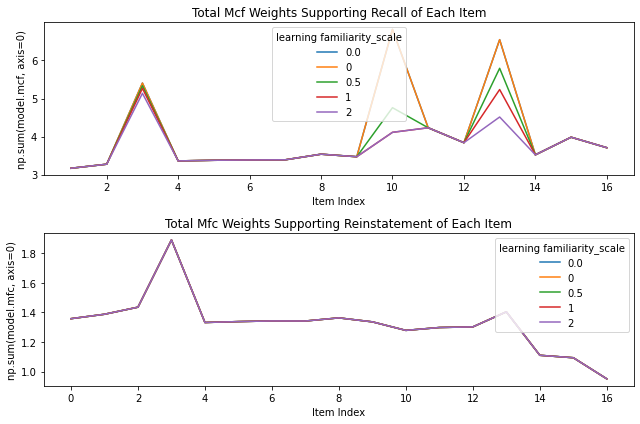

mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.0 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.5 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 1 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 2 2


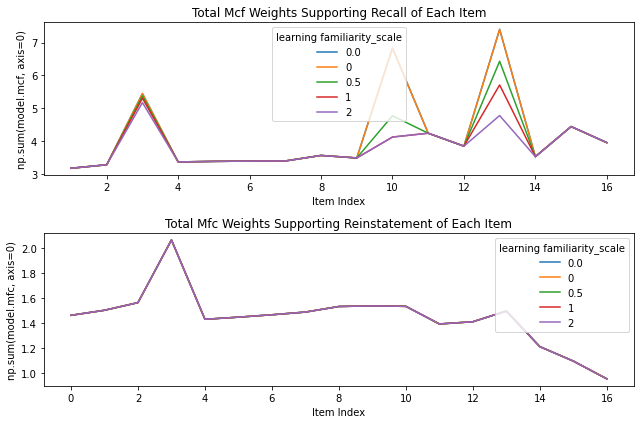

mfc_learning_scale, mcf_learning_scale, drift_scale
0 0.0 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0 0 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0 0.5 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0 1 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0 2 2


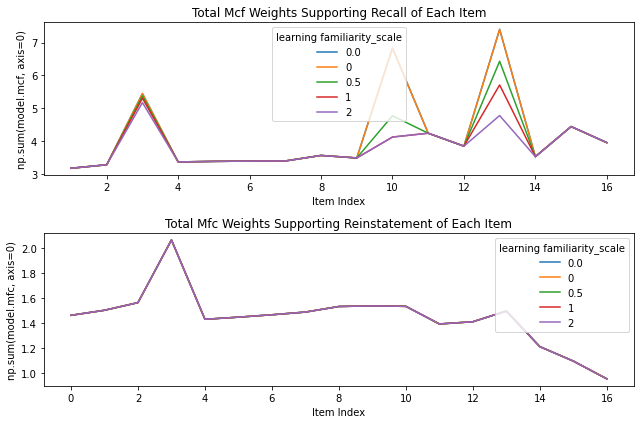

mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0.0 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 0.5 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 1 2
mfc_learning_scale, mcf_learning_scale, drift_scale
0.5 2 2


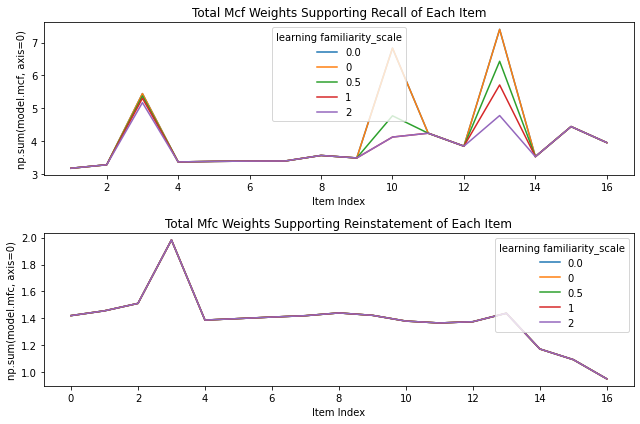

mfc_learning_scale, mcf_learning_scale, drift_scale
1 0.0 2
mfc_learning_scale, mcf_learning_scale, drift_scale
1 0 2
mfc_learning_scale, mcf_learning_scale, drift_scale
1 0.5 2
mfc_learning_scale, mcf_learning_scale, drift_scale
1 1 2
mfc_learning_scale, mcf_learning_scale, drift_scale
1 2 2


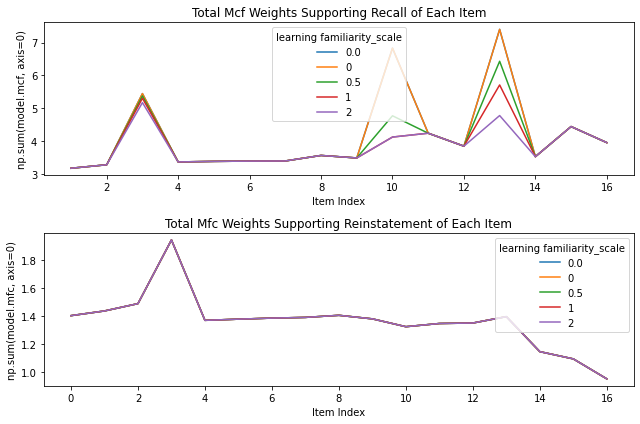

mfc_learning_scale, mcf_learning_scale, drift_scale
2 0.0 2
mfc_learning_scale, mcf_learning_scale, drift_scale
2 0 2
mfc_learning_scale, mcf_learning_scale, drift_scale
2 0.5 2
mfc_learning_scale, mcf_learning_scale, drift_scale
2 1 2
mfc_learning_scale, mcf_learning_scale, drift_scale
2 2 2


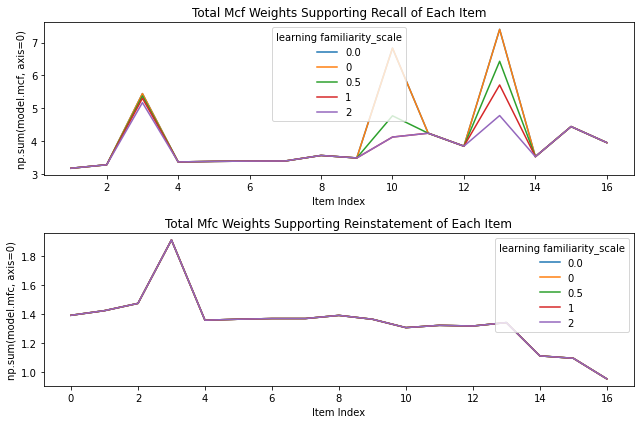

In [5]:
for drift_scale in [fit_values[-3]] + scale_range:

    for mfc_learning_scale in [fit_values[-1]] + scale_range:
    
        f, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=(9, 6))

        for mcf_learning_scale in [fit_values[-2]] + scale_range:

            print('mfc_learning_scale, mcf_learning_scale, drift_scale')
            print(mfc_learning_scale, mcf_learning_scale, drift_scale)
    
            test_params = parameters.copy()
            test_params['mfc_familiarity_scale'] = mfc_learning_scale
            test_params['mcf_familiarity_scale'] = mcf_learning_scale
            test_params['drift_familiarity_scale'] = drift_scale
            
            item_count = np.max(presentation)+1
            model = Classic_CMR(**{'item_count': item_count, 'presentation_count': len(presentation), **test_params})

            # simulate study events
            model.experience(np.eye(model.item_count, model.item_count)[presentation])

            #plot_states(model.mcf, 'Final Mcf')
            ax1.plot(np.arange(item_count)[1:], np.sum(model.mcf, axis=0)[1:], label=str(mcf_learning_scale))
            ax2.plot(np.arange(item_count+2)[1:-1] - 1, np.sum(model.mfc, axis=0)[1:-1], label=str(mcf_learning_scale))
        
        ax2.legend(title='learning familiarity_scale')
        ax2.set_title('Total Mfc Weights Supporting Reinstatement of Each Item')
        ax2.set_xlabel('Item Index')
        ax2.set_ylabel('np.sum(model.mfc, axis=0)')
        
        ax1.legend(title='learning familiarity_scale')
        ax1.set_title('Total Mcf Weights Supporting Recall of Each Item')
        ax1.set_xlabel('Item Index')
        ax1.set_ylabel('np.sum(model.mcf, axis=0)')
        plt.tight_layout()
        plt.show()

With increased values of our familiarity scale parameter, the difference in context-to-item associative weights as a function of spacing also increases

Weights in $M^{FC}$, which help determine how context is updated when an item is encoded or retrieved, are however consistent across values of the familiarity_scale parameter.

## How Do Values of $\zeta_i$ Configure Recall?

After items are studied, values in $M^{CF}$ configure the activation of each item during recall as context evolves:

$$
a = M^{CF}c
$$

With the probability of recalling items based on their activation varying according to:

$$
P(i, j) = (1-P(stop, j))\frac{a^{\tau}_i}{\sum_{k}^{N}a^{\tau}_k}
$$

Consequently, the recall rate of a repeatedly studied item depends on the spacing between its presentations as well as factors like the rate of contextual drift during encoding (higher contextual drift means lower familiarity upon encoding the second presentation of an item) and the value of our familiarity scale parameter.

$\tau$ is another parameter configuring how influential deficient encoding is on predicted recalls; at high values of $\tau$, small differences in context-to-item associations encoded in $M^{CF}$ and retrievable given a state of $c$ drive stronger differences between items' probability of being recalled.

To explore these features, we use typical parameter values for CMR and the trial structure and data from the Lohnas & Kahana (2014) study.

In [14]:
from compmemlearn.datasets import prepare_lohnas2014_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


### How Do Values of $\zeta_s$ Configure the Spacing Effect?
We intend for $\zeta_s$ to control the distinction in learning between highly familiar and highly novel items. Greater values for the parameter should correspond to less learning for mass-repeated items relative to that of spaced-repeated items, but no difference in learning for singly-presented items. We'll demo this functionality using the trials presented by Lohnas & Kahana (2015) to study repetition memory.

mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.0 0.0


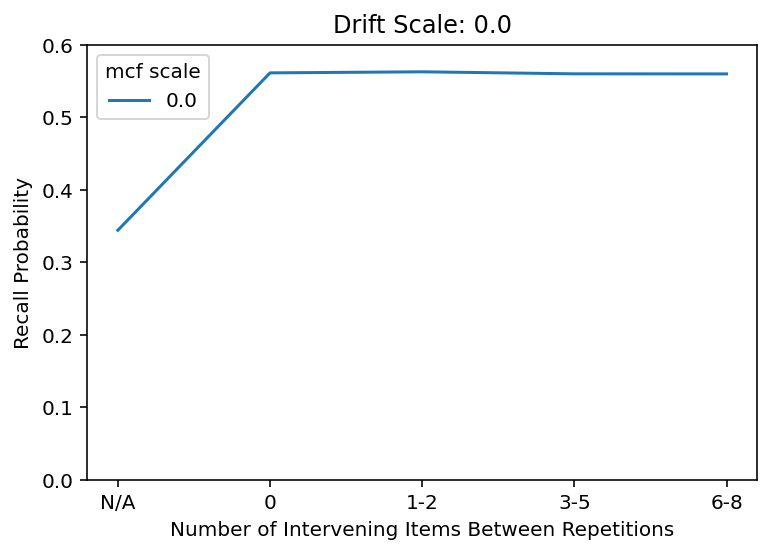

In [17]:
from compmemlearn.analyses import sim_recall_probability_by_lag

regenerate_sim = True

if regenerate_sim:
    for drift_scale in [fit_values[-3]] + scale_range:
        for mfc_learning_scale in [fit_values[-1]] + scale_range:
            for mcf_learning_scale in [fit_values[-2]] + scale_range:

                print('mfc_learning_scale, mcf_learning_scale, drift_scale')
                print(mfc_learning_scale, mcf_learning_scale, drift_scale)
                
                test_params = parameters.copy()
                test_params['drift_familiarity_scale'] = drift_scale
                test_params['mfc_familiarity_scale'] = mfc_learning_scale
                test_params['mcf_familiarity_scale'] = mcf_learning_scale

                result = sim_recall_probability_by_lag(
                    presentations[list_types==4], experiment_count=200, **test_params)[-1]
                plt.plot(['N/A', '0', '1-2', '3-5', '6-8'], result, label=str(mcf_learning_scale))
                break

            plt.xlabel('Number of Intervening Items Between Repetitions')
            plt.ylabel('Recall Probability')
            plt.legend(title='mcf scale')
            plt.ylim([0, .6])
            plt.title('Drift Scale: {}'.format(drift_scale))
            plt.show()
            break
        break

### How Do Values of $\zeta_s$ Configure Temporal Contiguity With Secondary Item Presentations?
Weights in $M^{CF}$ do not just configure the overall probability of recalling an item. Since the state of context depends on prior items encoded or retrieved and  $M^{CF}$ encodes context-to-item associations, differences in $M^{CF}$ learning rates for presentations of an item as enforced by the differential encoding mechanism must also the rate of transition between different items during recall.

In particular, weaker learning for the second presentation of a repeated item compared to the first should enforce greater rate of transitions between the repeated item and other items presented near its first presentation.

mfc_learning_scale, mcf_learning_scale, drift_scale
0.0 0.0 0.0


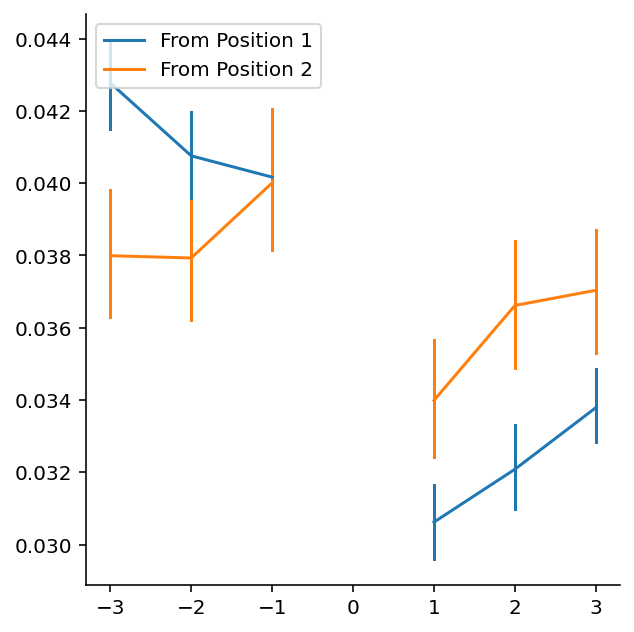

In [18]:
from compmemlearn.analyses import sim_alternative_contiguity_test
import seaborn as sns

regenerate_sim = True
lag_threshold = 6

if regenerate_sim:
      for drift_scale in [fit_values[-3]] + scale_range:
        for mfc_learning_scale in [fit_values[-1]] + scale_range:
            for mcf_learning_scale in [fit_values[-2]] + scale_range:

                print('mfc_learning_scale, mcf_learning_scale, drift_scale')
                print(mfc_learning_scale, mcf_learning_scale, drift_scale)
        
                # 5.95103128e-01, 6.72477663e+02, 2.19294172e+02
                test_params = parameters.copy()
                test_params['drift_familiarity_scale'] = drift_scale
                test_params['mfc_familiarity_scale'] = mfc_learning_scale
                test_params['mcf_familiarity_scale'] = mcf_learning_scale

                df = sim_alternative_contiguity_test(
                    presentations[list_types>3], experiment_count=100, lag_threshold=lag_threshold, repetition_count=2, **test_params)

                max_lag = lag_threshold/2
                filt_neg = f'{-max_lag} <= lag < 0'
                filt_pos = f'0 < lag <= {max_lag}'

                g = sns.FacetGrid(df, height=4.5)
                g.map_dataframe(
                    lambda data, **kws: sns.lineplot(
                        data=data.query(filt_neg), x='lag', y='prob', hue='locus', err_style='bars', **kws)
                )

                g.map_dataframe(
                    lambda data, **kws: sns.lineplot(
                        data=data.query(filt_pos), x='lag', y='prob', hue='locus', err_style='bars', **kws)
                )

                plt.legend(['From Position {}'.format(i+1) for i in range(2)], loc='upper left')
                #plt.title('Stronger Contiguity For First Presentation of an Item\n(Minimum Lag = {})'.format(lag_threshold))
                plt.tight_layout()
                plt.show()
                break
            break
        break